<a href="https://colab.research.google.com/github/gideon94/lstm_sentiment_analysis/blob/master/LSTM_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Pull imdb dataset

!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2020-04-12 22:24:50--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  20.7MB/s    in 7.0s    

2020-04-12 22:24:58 (11.4 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [0]:
#Extract tar file

!tar -xvf aclImdb_v1.tar.gz
!mv aclImdb dataset

In [0]:
#Import libraries

import re
import os
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sns  
import tensorflow as tf
nltk.download('stopwords')
import matplotlib.pyplot as plt
from tensorflow import keras
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#Combine and extract dataset 

features = []
labels = []
for category in ['pos', 'neg']:
  dataset_path = os.path.join('dataset', 'train', category)
  for fname in sorted(os.listdir(dataset_path)):
    if fname.endswith('.txt'):
      with open(os.path.join(dataset_path, fname),encoding="utf8") as f:
        features.append(f.read())
        labels.append(0 if category == 'neg' else 1)

In [0]:
len(features),len(labels)

(25000, 25000)

In [0]:
#Preprocessing - Removing stopwords, stemming, removing unwanted expressions, shuffling data

df = pd.DataFrame(list(zip(features, labels)),columns=['features','labels'])

stop = stopwords.words('english')
stem = PorterStemmer()

df['features'] = df['features'].apply(lambda x: " ".join(stem.stem(item.lower()) for item in x.split() if item not in stop))
df['features'] = df['features'].replace(to_replace=r'[^0-9a-zA-Z ]+',value='',regex=True)
df['features'] = df['features'].replace(to_replace=r'<br',value='',regex=True)
df.head()

,features,labels
0,bromwel high cartoon comedy it ran time progra...,1
1,homeless or houseless georg carlin stated issu...,1
2,brilliant overact lesley ann warren best drama...,1
3,thi easili underr film inn brook cannon sure f...,1
4,thi typic mel brook film it much less slapstic...,1


Accuracy score of fold  1 :  78.92
Accuracy score of fold  2 :  78.32000000000001
Accuracy score of fold  3 :  78.38000000000001
Accuracy score of fold  4 :  77.7
Accuracy score of fold  5 :  78.48
Accuracy score of fold  6 :  78.68
Accuracy score of fold  7 :  79.2
Accuracy score of fold  8 :  78.52
Accuracy score of fold  9 :  78.88
Accuracy score of fold  10 :  77.60000000000001

Average Accuracy score of model: 78.468


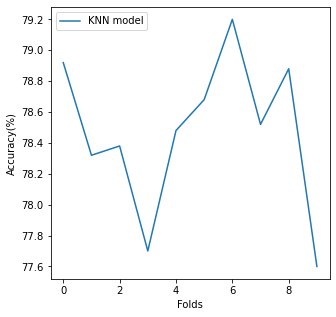

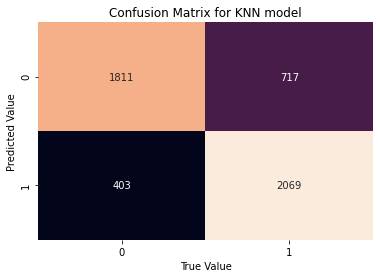

In [0]:
# Naive K-Nearest Neighbors model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

Accuracy_10_fold = []  
for i in range(10):
    df = df.sample(frac=1)   #Shuffling data for 10 folds
    train_test_cutoff = int(.80 * len(df)) 
    training_sentences = df[:train_test_cutoff]
    testing_sentences = df[train_test_cutoff:]
    X_train = training_sentences['features']
    X_test = testing_sentences['features']
    y_train = training_sentences['labels']
    y_test = testing_sentences['labels']
    y_test_org = y_test
    
    cvec = TfidfVectorizer().fit(X_train,X_test)
    X_train1 = cvec.transform(X_train)
    X_test1 = cvec.transform(X_test)

    clf = KNeighborsClassifier(n_neighbors=5).fit(X_train1, y_train)
    y_pred = clf.predict(X_test1)
    accuracy = accuracy_score(y_test,y_pred)
    Accuracy_10_fold.append(accuracy*100)  #compute accuracy score for each split  
    print("Accuracy score of fold ", i+1, ": ", Accuracy_10_fold[i])  

Avg_Accuracy = np.mean(Accuracy_10_fold)  # returns mean of all the scores  
print("\nAverage Accuracy score of model:", Avg_Accuracy)

#Performance curve for KNN 
plt.figure(figsize=(5,5)) 
plt.plot(range(10), Accuracy_10_fold, label = 'KNN model')  
plt.ylabel('Accuracy(%)')  
plt.xlabel('Folds')  
plt.legend()  
plt.show()  

#Confusion matrix for KNN
matrix = confusion_matrix(y_test, y_pred)   
plot1 = sns.heatmap(matrix,annot=True,cbar=False,fmt='d')  
plt.ylabel('Predicted Value')  
plt.xlabel('True Value')  
plt.title('Confusion Matrix for KNN model')  
plt.show()  


In [0]:
#Preprocessing for Keras model - Tokenizing, padding and sequencing

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

vocab = list()
vocab_file = "dataset/imdb.vocab"
vocab = open(vocab_file,"r").readlines()
vocab_size = len(vocab) #Vocabulary size

max_len = 500
tokenizer = Tokenizer(num_words=vocab_size)
X_train = training_sentences['features'].tolist()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,max_len)

X_test = testing_sentences['features'].tolist()
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test,max_len)

y_train= to_categorical(y_train)
y_test = to_categorical(y_test)

len(X_train), len(y_train), len(X_test), len(y_test)

(20000, 20000, 5000, 5000)

In [0]:
#Acceptor recurrent neural network with LSTM layer

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = vocab_size,output_dim= 32,input_length =max_len))
model.add(tf.keras.layers.LSTM(64,dropout=0.2,recurrent_dropout=0.2, return_sequences=False))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x = X_train,y= y_train ,epochs=10,batch_size = 256, validation_split=0.2)

63/63 [==============================] - 92s 1s/step - loss: 0.0258 - accuracy: 0.9946 - val_loss: 0.4176 - val_accuracy: 0.8702
Epoch 7/10
63/63 [==============================] - 95s 2s/step - loss: 0.0198 - accuracy: 0.9958 - val_loss: 0.5744 - val_accuracy: 0.8635
Epoch 8/10
63/63 [==============================] - 95s 2s/step - loss: 0.0107 - accuracy: 0.9980 - val_loss: 0.6630 - val_accuracy: 0.8630
Epoch 9/10
63/63 [==============================] - 93s 1s/step - loss: 0.0161 - accuracy: 0.9964 - val_loss: 0.4422 - val_accuracy: 0.8493
Epoch 10/10
63/63 [==============================] - 94s 1s/step - loss: 0.0115 - accuracy: 0.9971 - val_loss: 0.5374 - val_accuracy: 0.8658
Epoch 1/10
63/63 [==============================] - 95s 2s/step - loss: 0.6861 - accuracy: 0.6637 - val_loss: 0.6505 - val_accuracy: 0.7542
Epoch 2/10
63/63 [==============================] - 95s 2s/step - loss: 0.4950 - accuracy: 0.8355 - val_loss: 0.3690 - val_accuracy: 0.8543
Epoch 3/10
63/63 [============

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


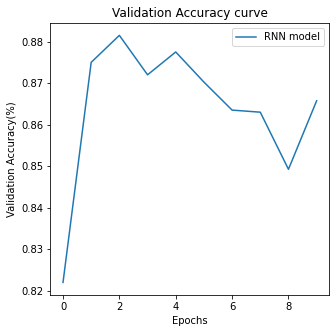

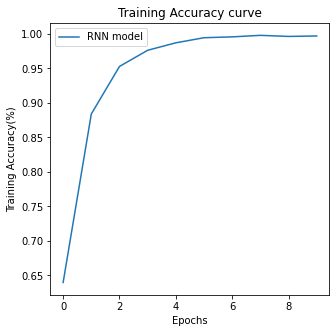

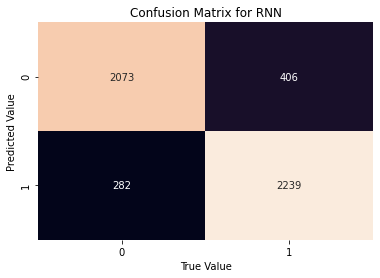

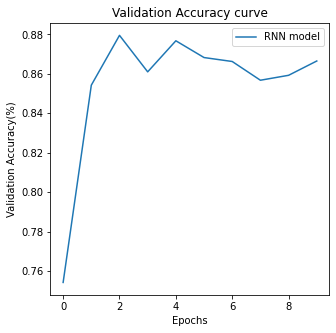

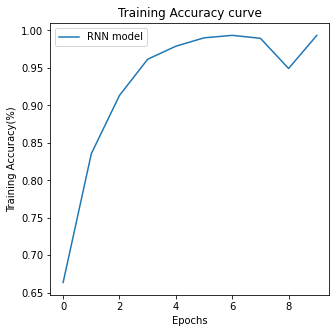

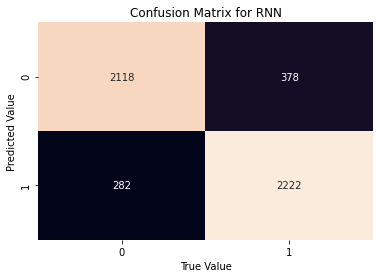

In [0]:
#Predictions on test data
y_pred1 = model.predict_classes(X_test, batch_size = 256)
val = history.history
val_accuracy = val['val_accuracy']
train_accuracy = val['accuracy']


#Performance curves for RNN 
plt.figure(figsize=(5,5))  
plt.title('Validation Accuracy curve') 
plt.plot(range(10), val_accuracy, label = 'RNN model')
plt.ylabel('Validation Accuracy(%)')  
plt.xlabel('Epochs')  
plt.legend()  
plt.show()  

plt.figure(figsize=(5,5)) 
plt.title('Training Accuracy curve')   
plt.plot(range(10), train_accuracy, label = 'RNN model')
plt.ylabel('Training Accuracy(%)')  
plt.xlabel('Epochs')  
plt.legend()  
plt.show() 

#Confusion matrix for RNN
matrix1 = confusion_matrix(y_test_org, y_pred1)  
plot1 = sns.heatmap(matrix1,annot=True,cbar=False,fmt='d')  
plt.ylabel('Predicted Value')  
plt.xlabel('True Value')  
plt.title('Confusion Matrix for RNN')  
plt.show()